## Model Inference
---

In [1]:
!pip install ultralytics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 513.4/513.4 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 kB 10.2 MB/s eta 0:00:00


In [2]:
from ultralytics import YOLO

import cv2
from google.colab.patches import cv2_imshow

import os
import numpy as np
from tqdm.notebook import tqdm

from IPython.display import Video

### Default Inference
---

In [ ]:
# restore model
model = YOLO("/content/drive/MyDrive/SupermarketScanner/runs/segment/smkt_scanner/weights/best.pt")

Results saved to runs/segment/predict


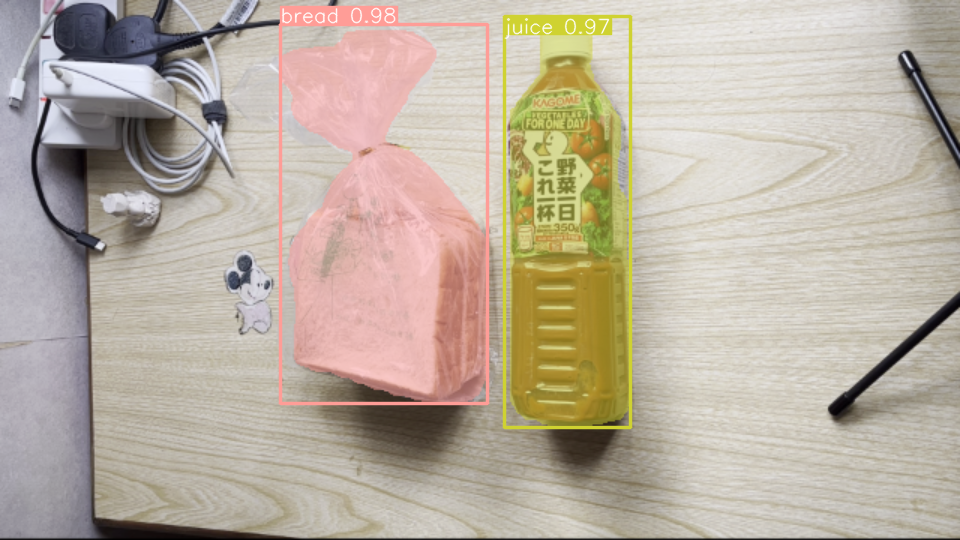

In [ ]:
# image prediction
img_pred = model.predict(
    source="/content/drive/MyDrive/SupermarketScanner/imgs/sample_image.png",
    save=True,
    verbose=False
)

cv2_imshow(img_pred[0].plot())

In [ ]:
# video prediction
vid_pred = model.predict(
    source="/content/drive/MyDrive/SupermarketScanner/vids/sample_video.mp4",
    save=True,
    verbose=False,
)

!ffmpeg -i /content/runs/segment/predict/sample_video.mp4 -crf 18 -preset veryfast -hide_banner -loglevel error -vcodec libx264 /content/runs/segment/predict/sample_video_tmp.mp4
!mv /content/runs/segment/predict/sample_video_tmp.mp4 /content/runs/segment/predict/sample_video.mp4

FRAC = 0.7
Video(
    data="/content/runs/segment/predict/sample_video.mp4",
    embed=True,
    height=int(720*FRAC),
    width=int(1280*FRAC),
)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!cp -a /content/runs/segment/predict /content/drive/MyDrive/SupermarketScanner/runs/segment

### Custom Inference
---

In [3]:
class SupermarketScanner(YOLO):
    def __init__(self, weights):
        # clone YOLO model
        super().__init__(weights)
        
        # create global variables
        self.GOODS_LABELS = self.model.names
        
        self.GOODS_ATTR = {
            "colour": {
                "blueberry": (100, 149, 237),  # cornflowerblue
                "bread": (221, 160, 221),  # plum
                "chicken": (255, 255, 255),  # white
                "egg": (255, 215, 0),  # gold
                "juice": (255, 99, 71),  # tomato
                "melon": (152, 251, 152),  # palegreen
                "sushi": (255, 228, 181),  # moccasin
                "watermelon": (255, 192, 203),  # pink
            },
            "price": {
                "blueberry": 20,
                "bread": 10,
                "chicken": 60,
                "egg": 30,
                "juice": 20,
                "melon": 70,
                "sushi": 50,
                "watermelon": 80,
            },
        }
        
        self.PTH_DEST = "runs/segment/custom_predict"
        
        return None
        
    def draw_segment_on_object(self, img, cls, masks, boxes):
        for idx, obj in enumerate(cls):
            TRANS_ALPHA = .5
            TRANS_BETA = 1 - TRANS_ALPHA
            
            # get object's attribute
            colour = self.GOODS_ATTR["colour"][obj][::-1]
            price = self.GOODS_ATTR["price"][obj]
            
            seg = np.int32(masks.xy[idx].tolist())
            box = boxes.xyxy.cpu().numpy()[idx]
            
            # fill object with colour pixels
            obj_seg = np.zeros_like(img, np.uint8)
            cv2.fillPoly(img=obj_seg, pts=[seg], color=colour)
            
            mask = obj_seg.astype(bool)
            img[mask] = cv2.addWeighted(
                src1=img, src2=obj_seg,
                alpha=TRANS_ALPHA, beta=TRANS_BETA, gamma=0,
            )[mask]
            
            cv2.polylines(
                img=img, pts=[seg], isClosed=True,
                color=colour, thickness=2,
            )
            
            # add description on centroid of object
            x = box[[0,2]].mean().astype("int16")
            x = x-50 if x-50 > 0 else x
            y = box[[1,3]].mean().astype("int16")
            
            cv2.putText(
                img=img, text=f"{obj}: HKD {price}",
                org=(x, y),
                fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=1,
                color=(0, 0, 0), thickness=2,
            )
        
        return img
    
    def draw_object_list(self, img, cls):
        TRANS_ALPHA = .1
        TRANS_BETA = 1 - TRANS_ALPHA
        TXT_STYLE = cv2.FONT_HERSHEY_TRIPLEX
        TXT_SCALE = .8
        TXT_THICK = 1
        
        # calculate sales amount and total units
        amt, qty = {}, {}
        for obj in cls:
            amt[obj] = amt.get(obj, 0) + self.GOODS_ATTR["price"][obj]
            qty[obj] = qty.get(obj, 0) + 1
        
        # calculate size of object list
        msgs = []
        w_max, h_max = 0, 0
        for prod, unit in qty.items():
            msg = f"- {unit} {prod}: HKD {amt[prod]}"
            msgs.append(msg)
            
            (w, h), _ = cv2.getTextSize(
                text=msg,
                fontFace=TXT_STYLE, fontScale=TXT_SCALE,
                thickness=TXT_THICK
            )
            w_max = max(w_max, w)
            h_max = max(h_max, h)
        
        # add object list on top-left of image
        obj_list = np.zeros_like(img, np.uint8)
        cv2.rectangle(
            img=obj_list,
            pt1=(20, 10), pt2=(40+w_max, 10+(h_max+10)*len(msgs)),
            color=(255, 255, 255), thickness=-1,
        )
        
        mask = obj_list.astype(bool)
        img[mask] = cv2.addWeighted(
            src1=img, src2=obj_list,
            alpha=TRANS_ALPHA, beta=TRANS_BETA, gamma=0,
        )[mask]
        
        for line, msg in enumerate(msgs):
            cv2.putText(
                img=img, text=msg,
                org=(30, 30+line*30),
                fontFace=TXT_STYLE, fontScale=TXT_SCALE,
                color=(0, 0, 0), thickness=TXT_THICK
            )
        
        return img, amt, qty
    
    def draw_transaction_summary(self, img, amt, qty):
        TXT_STYLE = cv2.FONT_HERSHEY_TRIPLEX
        TXT_SCALE = .9
        TXT_THICK = 1
        
        # add blank box on middle of image
        h, w, _ = img.shape
        (x1, y1) = (w//4, h//4)
        (x2, y2) = (w*3//4, h*3//4)
        
        cv2.rectangle(
            img=img,
            pt1=(x1, y1), pt2=(x2, y2),
            color=(220, 220, 220), thickness=-1,
        )
        
        cv2.rectangle(
            img=img,
            pt1=(x1, y1), pt2=(x2, y2),
            color=(0, 0, 0), thickness=2,
        )
        
        # add text to transaction summary box
        msgs = [
            f"Found {sum(qty.values())} items on the desk",
            f"Total HKD {sum(amt.values())} - Thank you",
        ]
        
        x = np.mean([x1, x2]).astype("int16")
        y = np.mean([y1, y2]).astype("int16")
        margin = (y-y1) // 3
        
        for idx, msg in enumerate(msgs):
            (w, h), _ = cv2.getTextSize(
                text=msg,
                fontFace=TXT_STYLE, fontScale=TXT_SCALE,
                thickness=TXT_THICK
            )
            
            cv2.putText(
                img=img, text=msg,
                org=(x-w//2, y+margin*(-1)**(idx+1)),
                fontFace=TXT_STYLE, fontScale=TXT_SCALE,
                color=(0, 0, 0), thickness=TXT_THICK,
            )
        
        return img
    
    def custom_predict_image(self, src, trx_smry=False, out_qty=False, save=True):
        # predict image
        res = self.predict(source=src, verbose=False)[0]
        img = res.orig_img
        
        # extract predicted results
        goods = res.boxes.cls.cpu().numpy()
        goods = [self.GOODS_LABELS[idx] for idx in goods]
        amt, qty = {}, {}
        
        # add segment and goods count
        if len(goods):
            img = self.draw_segment_on_object(img, goods, res.masks, res.boxes)
            img, amt, qty = self.draw_object_list(img, goods)
        
        # add transaction summary
        if trx_smry:
            img = self.draw_transaction_summary(img, amt, qty)
        
        # save image
        if save:
            os.makedirs(self.PTH_DEST, exist_ok=True)
            
            if isinstance(src, str):
                img_name = src.split("/")[-1]
            else:
                img_name = "results.png"
            pth_out = f"{self.PTH_DEST}/{img_name}"
            
            flag = cv2.imwrite(pth_out, img)
            if flag:
                print(f"Results saved to \033[1m{self.PTH_DEST}\033[0m")
        
        if out_qty:
            return img, qty
        else:
            return img
    
    def resize_frame(self, frame, scale):
        width = frame.shape[1]*scale // 100
        height = frame.shape[0]*scale // 100
        
        resized = cv2.resize(
            src=frame,
            dsize=(width, height),
            interpolation=cv2.INTER_AREA,
        )
        
        return resized
    
    def custom_predict_video(self, src, trx_smry=True):
        SCALE_PCT = 50
        
        os.makedirs(self.PTH_DEST, exist_ok=True)
        vid_name = src.split("/")[-1]
        pth_out = f"{self.PTH_DEST}/{vid_name}"
        
        # extract video information
        video = cv2.VideoCapture(src)
        height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
        width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
        fps = video.get(cv2.CAP_PROP_FPS)
        frames = []
        
        # scale video for better performance
        if SCALE_PCT != 100:
            width = width * SCALE_PCT // 100
            height = height * SCALE_PCT // 100
        
        # build video output
        vid_codec = "MP4V"
        output_video = cv2.VideoWriter(
            filename=pth_out,
            fourcc=cv2.VideoWriter_fourcc(*vid_codec),
            fps=fps, frameSize=(width, height),
        )
        
        # create a queue for storing 3-second frame
        # display transaciton summary if the number of products remains unchanged
        flag_smry = False
        hist = [{}] * 24 * 3
        
        for i in tqdm(range(int(video.get(cv2.CAP_PROP_FRAME_COUNT)))):
            flag, frame = video.read()
            
            if flag:
                frame  = self.resize_frame(frame, SCALE_PCT)
                frame, qty = self.custom_predict_image(
                    src=frame,
                    trx_smry=flag_smry,
                    out_qty=True,
                    save=False,
                )
                
                # update queue and transaction summary flag
                hist.pop(0)
                hist.append(qty)
                flag_smry = trx_smry and len(hist[0]) and hist[:10] == hist[-10:]
            
            frames.append(frame)
            output_video.write(frame)
        
        output_video.release()
        
        print(f"Results saved to \033[1m{self.PTH_DEST}\033[0m")
        
        return None

In [4]:
model = SupermarketScanner("/content/drive/MyDrive/SupermarketScanner/runs/segment/smkt_scanner/weights/best.pt")

Results saved to runs/segment/custom_predict


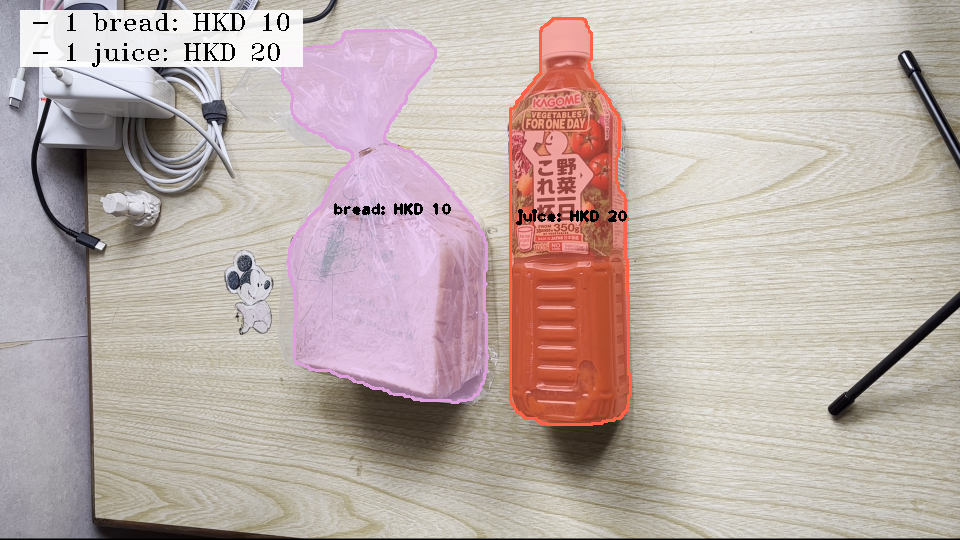

In [5]:
# image prediction
img_pred = model.custom_predict_image(
    src="/content/drive/MyDrive/SupermarketScanner/imgs/sample_image.png",
    trx_smry=False,
    out_qty=False,
    save=True,
)

cv2_imshow(img_pred)

In [6]:
model.custom_predict_video(
    src="/content/drive/MyDrive/SupermarketScanner/vids/sample_video.mp4",
    trx_smry=True,
)

!ffmpeg -i /content/runs/segment/custom_predict/sample_video.mp4 -crf 18 -preset veryfast -hide_banner -loglevel error -vcodec libx264 /content/runs/segment/custom_predict/sample_video_tmp.mp4
!mv /content/runs/segment/custom_predict/sample_video_tmp.mp4 /content/runs/segment/custom_predict/sample_video.mp4

FRAC = 0.7
Video(
    data="/content/runs/segment/custom_predict/sample_video.mp4",
    embed=True,
    height=int(720*FRAC),
    width=int(1280*FRAC),
)

Output hidden; open in https://colab.research.google.com to view.

In [7]:
!cp -a /content/runs/segment/custom_predict/ /content/drive/MyDrive/SupermarketScanner/runs/segment